# Dams valley management

Consider two dams in the same valley. These two dams are connected together, as we suppose that the water turbined by the first dam is an input of the second dam. The goal of this notebook is to show how to use the Stochastic Dual Dynamic Programming (SDDP) algorithm to find how to manage optimally these two dams. 

## Mathematical formulation:

Assume that we have a water inflow $W_t$ which arrives in the first dam between $t$ and $t+1$. This dam turbines a quantity $U_t^1$ of water, and spill a quantity $S_t^1$. 

Its dynamic is: 

$$ X_{t+1}^1 = X_{t}^1 + W^t - U_t^1 - S_t^1 $$

The turbined flow arrives in the second dam, which turbines a quantity $U_t^2$ and spills a quantity $S_t^2$. So its dynamic is:

$$ X_{t+1}^2 = X_{t}^2 + U_t^1 + S_t^1 - U_t^2 - S_t^2 $$

Thus, we could define the state:
$$ X_t = (X_t^1, X_t^2)$$

and the control:
$$U_t = (U_t^1, U_t^2, S_t^1, S_t^2) $$

The two turbines produce a quantity of electricity proportionnal to the flow turbined, and this electricity is sold into the market at a price $c_t$. So we gain at each timestep:

$$ C_t(X_t, U_t) = c_t  (U_t^1 + U_t^2) $$

Here, we suppose that costs are negative, as we sell electricity onto the network. 

We want to maximize our expected gains, so we minimize the following quantity:

$$ J = \mathbb{E} \left[ \sum_{i=1}^{T_f} C_t(X_t, U_t) \right]$$ 

## Problem formulation: 

First, we need to import some modules: 

In [2]:
push!(LOAD_PATH, "../../StochDynamicProgramming.jl/src")

using JuMP, Clp, StochDynamicProgramming, PyPlot

JuMP is the julia module for Mathematical Programming, 
  Clp the module calling a linear solver (can be replaced by CPLEX or Gurobi), 
 StochDynamicProgramming is a SDDP module in Julia, 
 PyPlot is used here to plot the results 
 

---
### Constants definition

Then, we define the constants of this problem: 

In [3]:
# Number of timesteps (as we manage the dams over a year, it is equal to the number of weeks):
TF = 52

# Capacity of dams: 
VOLUME_MAX = 100
VOLUME_MIN = 0

# Specify the maximum flow that could be turnined: 
CONTROL_MAX = round(Int, .4/7. * VOLUME_MAX) + 1
CONTROL_MIN = 0

# Some statistics about aleas (water inflow):
W_MAX = round(Int, .5/7. * VOLUME_MAX)
W_MIN = 0
DW = 1

T0 = 1

# Define aleas' space:
N_ALEAS = Int(round(Int, (W_MAX - W_MIN) / DW + 1))
ALEAS = linspace(W_MIN, W_MAX, N_ALEAS);


Now, we generate a random process to simulate the evolution of electricity prices over a year: 

In [4]:
COST = -66*2.7*(1 + .5*(rand(TF) - .5));

We could plot the evolution of prices with matplotlib: 

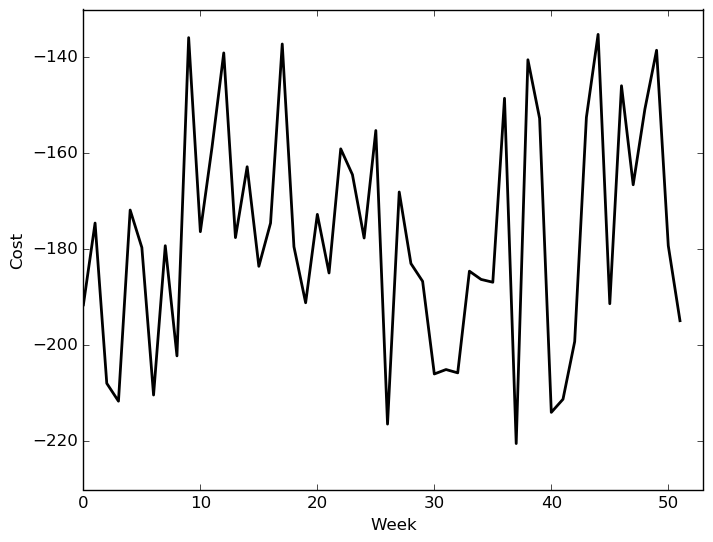

PyObject <matplotlib.text.Text object at 0x7f6e0d2af590>

In [5]:
plot(COST, color="k", lw=2)
xlim(0, 53)
xlabel("Week")
ylabel("Cost")

---
### Dynamic, costs and aleas


---

We could now define the dynamic of our system: 

In [6]:
# Define dynamic of the dam:
function dynamic(t, x, u, w)
    return [x[1] - u[1] - u[3] + w[1], x[2] - u[2] - u[4] + u[1] + u[3]]
end


dynamic (generic function with 1 method)

and the cost at time $t$:

In [7]:
# Define cost corresponding to each timestep:
function cost_t(t, x, u, w)
    return COST[t] * (u[1] + u[2])
end

cost_t (generic function with 1 method)

Now, we build a function to simulate the evolution of water inflow over one year. We aim to have less water in summer than in winter. 




In [8]:
"""Build aleas probabilities for each month."""
function build_aleas()
    aleas = zeros(N_ALEAS, TF)

    # take into account seasonality effects:
    unorm_prob = linspace(1, N_ALEAS, N_ALEAS)
    proba1 = unorm_prob / sum(unorm_prob)
    proba2 = proba1[N_ALEAS:-1:1]

    for t in 1:TF
        aleas[:, t] = (1 - sin(pi*t/TF)) * proba1 + sin(pi*t/TF) * proba2
    end
    return aleas
end


"""Build an admissible scenario for water inflow."""
function build_scenarios(n_scenarios::Int64, probabilities)
    scenarios = zeros(n_scenarios, TF)

    for scen in 1:n_scenarios
        for t in 1:TF
            Pcum = cumsum(probabilities[:, t])

            n_random = rand()
            prob = findfirst(x -> x > n_random, Pcum)
            scenarios[scen, t] = prob
        end
    end
    return scenarios
end

build_scenarios (generic function with 1 method)

We could test our generator with one scenario: 

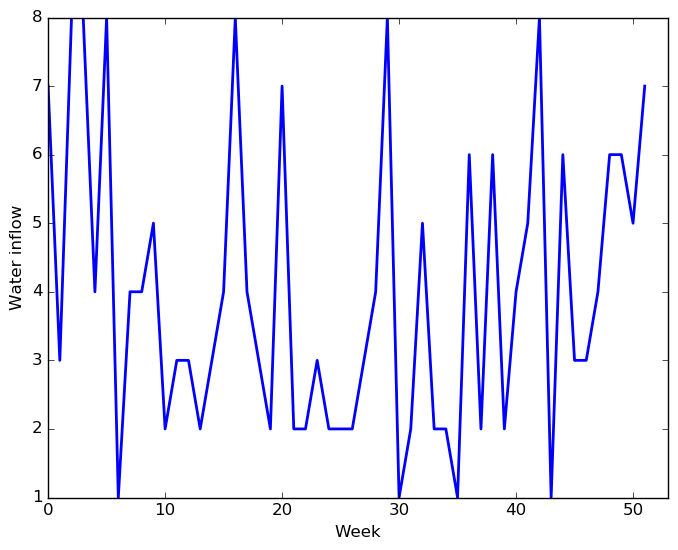

(0,53)

In [9]:
scenario = build_scenarios(1, build_aleas());

plot(scenario', lw=2, color="blue")
xlabel("Week")
ylabel("Water inflow")
xlim(0, 53)

---
To use these scenarios in SDDP, we must use a discrete distribution for each timestep. The following function generates `n_scenarios` and returns a vector of `NoiseLaw` corresponding to the evolution of aleas distribution along the time: 

In [10]:
"""Build probability distribution at each timestep.

Return a Vector{NoiseLaw}"""
function generate_probability_laws(n_scenarios)
    aleas = build_scenarios(n_scenarios, build_aleas())

    laws = Vector{NoiseLaw}(TF)

    # uniform probabilities:
    proba = 1/n_scenarios*ones(n_scenarios)

    for t=1:TF
        laws[t] = NoiseLaw(aleas[:, t], proba)
    end

    return laws
end

generate_probability_laws (generic function with 1 method)

---

## Solving the problem with SDDP

### SDDP model

We generate 10 scenarios and fit a probability distribution at each timestep: 

In [11]:
N_SCENARIO = 10
aleas = generate_probability_laws(10);

---
We define the bounds over the state and the control:

In [12]:
x_bounds = [(VOLUME_MIN, VOLUME_MAX), (VOLUME_MIN, VOLUME_MAX)];
u_bounds = [(CONTROL_MIN, CONTROL_MAX), (CONTROL_MIN, CONTROL_MAX), (0, Inf), (0, Inf)];

and the initial position $X_0$:

In [13]:
x0 = [50, 50]

2-element Array{Int64,1}:
 50
 50

We build an instance of `LinearDynamicLinearCostSPModel` to translate our problem in SDDP: 

In [15]:
model = LinearDynamicLinearCostSPmodel(TF, # number of timestep
                                        u_bounds, # control bounds
                                        x0, # initial state
                                        cost_t, # cost function
                                        dynamic, # dynamic function 
                                        aleas);


We add bounds to state:

In [17]:
set_state_bounds(model, x_bounds)

2-element Array{Tuple{Float64,Float64},1}:
 (0.0,100.0)
 (0.0,100.0)

---
### SDDP parameters

We define the parameters of the algorithm: 

In [18]:
# LP solver: 
solver = ClpSolver()
# Precision of the algorithm in percent: 
EPSILON = 0.05
# Maximum iterations: 
MAX_ITER = 20


params = SDDPparameters(solver, N_SCENARIO, EPSILON, MAX_ITER);

---
### SDDP solving

We could launch the SDDP algorithm to our problem: 

In [19]:
V, pbs = solve_SDDP(model, params, 1);

Initialize cuts
Pass number 1	Estimation of upper-bound: -47896.442220494806	Lower-bound: -120434.50673327091	Time: 0.938570854
Pass number 2	Estimation of upper-bound: -95722.64398379256	Lower-bound: -110494.93081636945	Time: 0.975922864
Pass number 3	Estimation of upper-bound: -101207.01933545082	Lower-bound: -107166.90476527679	Time: 1.151533908
Pass number 4	Estimation of upper-bound: -101121.28066080959	Lower-bound: -107088.26472870985	Time: 1.250806397
Pass number 5	Estimation of upper-bound: -103716.83932763092	Lower-bound: -106756.99829854601	Time: 1.341777311
Pass number 6	Estimation of upper-bound: -105439.4908375592	Lower-bound: -106607.22126320048	Time: 1.43541532
Pass number 7	Estimation of upper-bound: -103229.8660817095	Lower-bound: -106498.90550231005	Time: 1.564272087
Pass number 8	Estimation of upper-bound: -101081.30053693666	Lower-bound: -106488.36199593375	Time: 1.690731557
Pass number 9	Estimation of upper-bound: -102519.09049776544	Lower-bound: -106482.3689325039

The algorithm returns the bellman functions (`V`) and a vector of `JuMP.Model` used to approximate these functions with linear cuts. 



---
## Test SDDP with an example 

### Input scenario

We suppose given a scenario of inflows: 


In [20]:
alea_year = Array([7.0 7.0 8.0 3.0 1.0 1.0 3.0 4.0 3.0 2.0 6.0 5.0 2.0 6.0 4.0 7.0 3.0 4.0 1.0 1.0 6.0 2.0 2.0 8.0 3.0 7.0 3.0 1.0 4.0 2.0 4.0 1.0 3.0 2.0 8.0 1.0 5.0 5.0 2.0 1.0 6.0 7.0 5.0 1.0 7.0 7.0 7.0 4.0 3.0 2.0 8.0 7.0])


1x52 Array{Float64,2}:
 7.0  7.0  8.0  3.0  1.0  1.0  3.0  4.0  …  7.0  7.0  4.0  3.0  2.0  8.0  7.0

We store this scenario as a 3D array, so it could be used to compute a forward-pass:

In [21]:
aleas = zeros(52, 1, 1)
aleas[:, 1, 1] = alea_year;


---
### SDDP simulation

We have only one scenario, so we set the forwardPassNumber equal to 1: 

In [22]:
params.forwardPassNumber = 1

1

Find the optimal control with a forward simulation: 

In [24]:
costs, stocks = forward_simulations(model, params, V, pbs, aleas);

---
### Results 

The cost is: 

In [25]:
SDDP_COST = costs[1]
println("SDDP cost: ", SDDP_COST)

SDDP cost: -103291.41528811422


And the optimal solution is: 

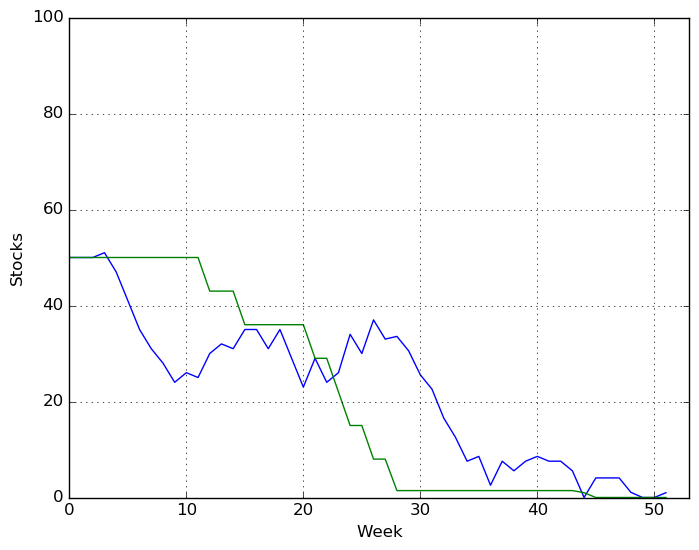

(0,53)

In [29]:
plot(stocks[:, :, 1])
plot(stocks[:, :, 2])
xlabel("Week")
ylabel("Stocks")
grid()
ylim(0, 100)
xlim(0, 53)

---
## Comparison with the deterministic solution 
To check the results given by SDDP, we solve the deterministic problem with JuMP: 

In [30]:
m = Model(solver=solver)


@defVar(m,  VOLUME_MIN  <= x1[1:(TF+1)]  <= VOLUME_MAX)
@defVar(m,  VOLUME_MIN  <= x2[1:(TF+1)]  <= VOLUME_MAX)
@defVar(m,  CONTROL_MIN <= u1[1:TF]  <= CONTROL_MAX)
@defVar(m,  CONTROL_MIN <= u2[1:TF]  <= CONTROL_MAX)
@defVar(m, u3[1:TF] >= 0)
@defVar(m, u4[1:TF] >= 0)

@setObjective(m, Min, sum{COST[i]*(u1[i] + u2[i]), i = 1:TF})

for i in 1:TF
    @addConstraint(m, x1[i+1] - x1[i] + u1[i] + u3[i] - alea_year[i] == 0)
    @addConstraint(m, x2[i+1] - x2[i] + u2[i] + u4[i] - u1[i] - u3[i] == 0)
end

@addConstraint(m, x1[1] == x0[1])
@addConstraint(m, x2[1] == x0[2])

status = solve(m)
println(status)

LP_COST = getObjectiveValue(m)
println("LP value: ", LP_COST)

Optimal
LP value: -106186.87920641087


And we plot the evolution of the stocks:

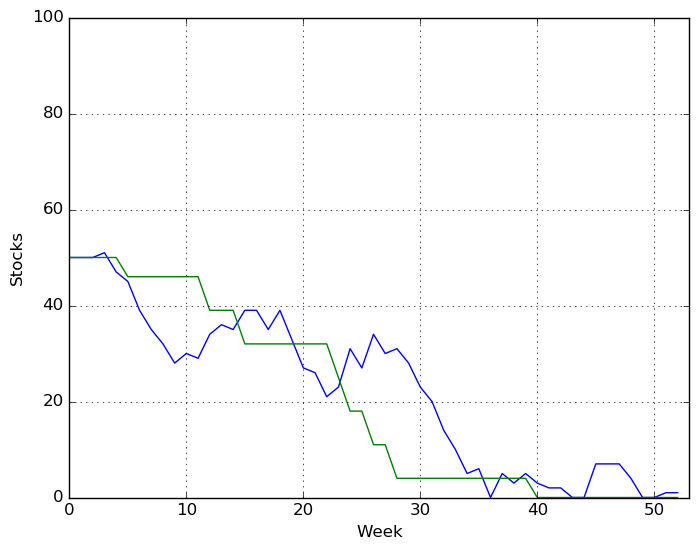

(0,53)

In [31]:
plot(getValue(x1))
plot(getValue(x2))
xlabel("Week")
ylabel("Stocks")
grid()
ylim(0, 100)
xlim(0, 53)

The solution given by the solver is more optimistic, as it assumes that the future is known in advance. 

If we consider the costs, we have a discrepancy between the two solutions :


In [32]:
abs((LP_COST - SDDP_COST)/LP_COST)


0.027267624210598706